In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

Part0: Data Creation

In [2]:
def generate_data_part(n_class0=150, n_class1=50, variance=0.5):
    """  
    This returns X, feature matrix and y, class labels
    """
    #Class0: Uniform distribution across 3 squares
    class0_points = []
    
    #Square1: [-1, 0] x [-1, 0]
    square1 = np.random.uniform(low=[-1, -1], high=[0, 0], size=(n_class0//3, 2))
    
    #Square2: [-1, 0] x [0, 1]
    square2 = np.random.uniform(low=[-1, 0], high=[0, 1], size=(n_class0//3, 2))
    
    #Square3: [0, 1] x [-1, 0]
    square3 = np.random.uniform(low=[0, -1], high=[1, 0], size=(n_class0 - 2*(n_class0//3), 2))
    
    class0_points = np.vstack([square1, square2, square3])
    
    #Class1: gaussian distribution
    class1_points = np.random.normal(loc=[0.5, 0.5], scale=[variance, variance], size=(n_class1, 2))
    
    #Combining data
    X = np.vstack([class0_points, class1_points])
    y = np.hstack([np.zeros(n_class0), np.ones(n_class1)])
    
    return X, y

In [3]:
def plot_data(X, y, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[y==0, 0], X[y==0, 1], c='blue', label='Class 0', alpha=0.6)
    plt.scatter(X[y==1, 0], X[y==1, 1], c='red', label='Class 1', alpha=0.6)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    plt.show()

In [4]:
X, y = generate_data_part()

In [5]:
len(X), len(y)

(200, 200)

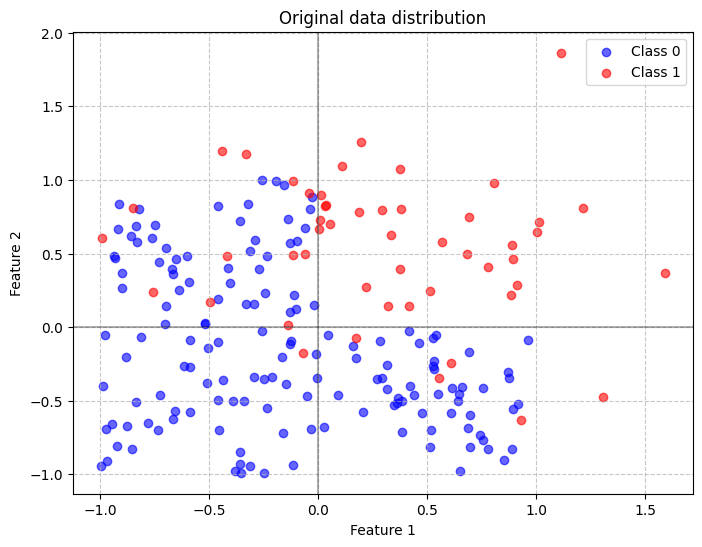

In [6]:
plot_data(X,y,'Original data distribution')

Spliting the data into training and testing sets

In [20]:
#Separating indices by class
class0_idx = np.where(y == 0)[0]
class1_idx = np.where(y == 1)[0]

print("Original class distribution, Class 0:", len(class0_idx), "Class 1:", len(class1_idx))

#Creating test set with exactly 50 samples from each class
test_class0_idx = np.random.choice(class0_idx, size=50, replace=False)
test_class1_idx = np.random.choice(class1_idx, size=50, replace=False)
test_idx = np.concatenate([test_class0_idx, test_class1_idx])
np.random.shuffle(test_idx)  # Shuffle the test indices

#Creatinh the test set
X_test = X[test_idx]
y_test = y[test_idx]

#Getting the remaining indices for training
remaining_class0_idx = np.setdiff1d(class0_idx, test_class0_idx)
remaining_class1_idx = np.setdiff1d(class1_idx, test_class1_idx)

print("Remaining samples - Class 0:", len(remaining_class0_idx), "Class 1:", len(remaining_class1_idx))

#Checking if we have any remaining class 1 samples
if len(remaining_class1_idx) == 0:
    #if no Class 1 samples remain, use the original Class 1 samples with replacement
    print("No Class 1 samples remaining for training, using test samples with replacement")
    class1_upsampled = resample(class1_idx, 
                               replace=True, 
                               n_samples=len(remaining_class0_idx), 
                               random_state=42)
else:
    #Upsampling for training
    class1_upsampled = resample(remaining_class1_idx, 
                               replace=True, 
                               n_samples=len(remaining_class0_idx), 
                               random_state=42)

#Combine and shuffle for training
train_idx = np.concatenate([remaining_class0_idx, class1_upsampled])
np.random.shuffle(train_idx)

#Create the training set
X_train = X[train_idx]
y_train = y[train_idx]

print("Train set class distribution:", np.unique(y_train, return_counts=True))
print("Test set class distribution:", np.unique(y_test, return_counts=True))

Original class distribution, Class 0: 150 Class 1: 50
Remaining samples - Class 0: 100 Class 1: 0
No Class 1 samples remaining for training, using test samples with replacement
Train set class distribution: (array([0., 1.]), array([100, 100]))
Test set class distribution: (array([0., 1.]), array([50, 50]))


In [25]:
def evaluate_classifier(X_train, y_train, X_test, y_test, classifier, cv=4):
    """
    Evaluating the classifier using 4-fold cross-validation. This returns the metrics dictionary and accuracy scores for variance calculation
    """
    #Stratified K-Fold for balanced splits
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    accuracies, precisions, recalls, aurocs = [], [], [], []
    
    for train_index, val_index in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        
        scaler = StandardScaler()
        X_train_fold_scaled = scaler.fit_transform(X_train_fold)
        X_val_fold_scaled = scaler.transform(X_val_fold)
        
        classifier.fit(X_train_fold_scaled, y_train_fold)
        y_pred = classifier.predict(X_val_fold_scaled)
        y_decision = classifier.decision_function(X_val_fold_scaled) if hasattr(classifier, 'decision_function') else classifier.predict_proba(X_val_fold_scaled)[:, 1]
        
        accuracies.append(accuracy_score(y_val_fold, y_pred))
        precisions.append(precision_score(y_val_fold, y_pred, zero_division=1))
        recalls.append(recall_score(y_val_fold, y_pred, zero_division=1))
        aurocs.append(roc_auc_score(y_val_fold, y_decision))
    
    # Evaluate on test set
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    classifier.fit(X_train_scaled, y_train)
    y_test_pred = classifier.predict(X_test_scaled)
    y_test_decision = classifier.decision_function(X_test_scaled) if hasattr(classifier, 'decision_function') else classifier.predict_proba(X_test_scaled)[:, 1]
    
    test_metrics = {
        'accuracy': accuracy_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred, zero_division=1),
        'recall': recall_score(y_test, y_test_pred, zero_division=1),
        'auroc': roc_auc_score(y_test, y_test_decision),
    }
    
    metrics = {
        'cv_accuracy': np.mean(accuracies),
        'cv_precision': np.mean(precisions),
        'cv_recall': np.mean(recalls),
        'cv_auroc': np.mean(aurocs),
        'accuracy_variance': np.var(accuracies),
        'test_accuracy': test_metrics['accuracy'],
        'test_precision': test_metrics['precision'],
        'test_recall': test_metrics['recall'],
        'test_auroc': test_metrics['auroc'],
    }
    
    return metrics

In [26]:
from sklearn.linear_model import Perceptron

Part1: Perceptron

In [27]:
perceptron = Perceptron(max_iter=1000, random_state=42)
perceptron_metrics = evaluate_classifier(X_train, y_train, X_test, y_test, perceptron)

print("\nPerceptron Classifier Results:")
print(f"Cross-Validation Accuracy: {perceptron_metrics['cv_accuracy']:.4f}")
print(f"Cross-Validation Precision: {perceptron_metrics['cv_precision']:.4f}")
print(f"Cross-Validation Recall: {perceptron_metrics['cv_recall']:.4f}")
print(f"Cross-Validation AUROC: {perceptron_metrics['cv_auroc']:.4f}")
print(f"Accuracy Variance: {perceptron_metrics['accuracy_variance']:.6f}")
print(f"Test Set Accuracy: {perceptron_metrics['test_accuracy']:.4f}")
print(f"Test Set Precision: {perceptron_metrics['test_precision']:.4f}")
print(f"Test Set Recall: {perceptron_metrics['test_recall']:.4f}")
print(f"Test Set AUROC: {perceptron_metrics['test_auroc']:.4f}")


Perceptron Classifier Results:
Cross-Validation Accuracy: 0.7800
Cross-Validation Precision: 0.7826
Cross-Validation Recall: 0.7900
Cross-Validation AUROC: 0.8472
Accuracy Variance: 0.002600
Test Set Accuracy: 0.7300
Test Set Precision: 0.6716
Test Set Recall: 0.9000
Test Set AUROC: 0.7484


Part2A: Linear SVM with Small C

In [30]:
svm_small_c = SVC(kernel='linear', C=0.01, random_state=42, probability=True)
svm_small_c_metrics = evaluate_classifier(X_train, y_train, X_test, y_test, svm_small_c)
print(f"Cross-Validation Accuracy: {svm_small_c_metrics['cv_accuracy']:.4f}")
print(f"Cross-Validation Precision: {svm_small_c_metrics['cv_precision']:.4f}")
print(f"Cross-Validation Recall: {svm_small_c_metrics['cv_recall']:.4f}")
print(f"Cross-Validation AUROC: {svm_small_c_metrics['cv_auroc']:.4f}")
print(f"Accuracy Variance: {svm_small_c_metrics['accuracy_variance']:.6f}")
print(f"Test Set Accuracy: {svm_small_c_metrics['test_accuracy']:.4f}")
print(f"Test Set Precision: {svm_small_c_metrics['test_precision']:.4f}")
print(f"Test Set Recall: {svm_small_c_metrics['test_recall']:.4f}")
print(f"Test Set AUROC: {svm_small_c_metrics['test_auroc']:.4f}")

Cross-Validation Accuracy: 0.8050
Cross-Validation Precision: 0.7845
Cross-Validation Recall: 0.8500
Cross-Validation AUROC: 0.9188
Accuracy Variance: 0.000875
Test Set Accuracy: 0.8400
Test Set Precision: 0.8542
Test Set Recall: 0.8200
Test Set AUROC: 0.8992


Part2B: Linear SVM with Large C

In [31]:
svm_large_c = SVC(kernel='linear', C=1000, random_state=42, probability=True)
svm_large_c_metrics = evaluate_classifier(X_train, y_train, X_test, y_test, svm_large_c)
print(f"Cross-Validation Accuracy: {svm_large_c_metrics['cv_accuracy']:.4f}")
print(f"Cross-Validation Precision: {svm_large_c_metrics['cv_precision']:.4f}")
print(f"Cross-Validation Recall: {svm_large_c_metrics['cv_recall']:.4f}")
print(f"Cross-Validation AUROC: {svm_large_c_metrics['cv_auroc']:.4f}")
print(f"Accuracy Variance: {svm_large_c_metrics['accuracy_variance']:.6f}")
print(f"Test Set Accuracy: {svm_large_c_metrics['test_accuracy']:.4f}")
print(f"Test Set Precision: {svm_large_c_metrics['test_precision']:.4f}")
print(f"Test Set Recall: {svm_large_c_metrics['test_recall']:.4f}")
print(f"Test Set AUROC: {svm_large_c_metrics['test_auroc']:.4f}")

Cross-Validation Accuracy: 0.8500
Cross-Validation Precision: 0.9004
Cross-Validation Recall: 0.7900
Cross-Validation AUROC: 0.9216
Accuracy Variance: 0.000900
Test Set Accuracy: 0.8300
Test Set Precision: 0.8667
Test Set Recall: 0.7800
Test Set AUROC: 0.8968


Part3A: Nonlinear SVM with Small C

In [33]:
svm_nonlinear_small_c = SVC(kernel='rbf', C=0.01, random_state=42, probability=True)
svm_nonlinear_small_c_metrics = evaluate_classifier(X_train, y_train, X_test, y_test, svm_nonlinear_small_c)
print(f"Cross-Validation Accuracy: {svm_nonlinear_small_c_metrics['cv_accuracy']:.4f}")
print(f"Cross-Validation Precision: {svm_nonlinear_small_c_metrics['cv_precision']:.4f}")
print(f"Cross-Validation Recall: {svm_nonlinear_small_c_metrics['cv_recall']:.4f}")
print(f"Cross-Validation AUROC: {svm_nonlinear_small_c_metrics['cv_auroc']:.4f}")
print(f"Accuracy Variance: {svm_nonlinear_small_c_metrics['accuracy_variance']:.6f}")
print(f"Test Set Accuracy: {svm_nonlinear_small_c_metrics['test_accuracy']:.4f}")
print(f"Test Set Precision: {svm_nonlinear_small_c_metrics['test_precision']:.4f}")
print(f"Test Set Recall: {svm_nonlinear_small_c_metrics['test_recall']:.4f}")
print(f"Test Set AUROC: {svm_nonlinear_small_c_metrics['test_auroc']:.4f}")

Cross-Validation Accuracy: 0.8550
Cross-Validation Precision: 0.8852
Cross-Validation Recall: 0.8200
Cross-Validation AUROC: 0.9220
Accuracy Variance: 0.000275
Test Set Accuracy: 0.8200
Test Set Precision: 0.8636
Test Set Recall: 0.7600
Test Set AUROC: 0.8916


Part3B: Nonlinear SVM with Large C

In [34]:
svm_nonlinear_large_c = SVC(kernel='rbf', C=1000, random_state=42, probability=True)
svm_nonlinear_large_c_metrics = evaluate_classifier(X_train, y_train, X_test, y_test, svm_nonlinear_large_c)
print(f"Cross-Validation Accuracy: {svm_nonlinear_large_c_metrics['cv_accuracy']:.4f}")
print(f"Cross-Validation Precision: {svm_nonlinear_large_c_metrics['cv_precision']:.4f}")
print(f"Cross-Validation Recall: {svm_nonlinear_large_c_metrics['cv_recall']:.4f}")
print(f"Cross-Validation AUROC: {svm_nonlinear_large_c_metrics['cv_auroc']:.4f}")
print(f"Accuracy Variance: {svm_nonlinear_large_c_metrics['accuracy_variance']:.6f}")
print(f"Test Set Accuracy: {svm_nonlinear_large_c_metrics['test_accuracy']:.4f}")
print(f"Test Set Precision: {svm_nonlinear_large_c_metrics['test_precision']:.4f}")
print(f"Test Set Recall: {svm_nonlinear_large_c_metrics['test_recall']:.4f}")
print(f"Test Set AUROC: {svm_nonlinear_large_c_metrics['test_auroc']:.4f}")

Cross-Validation Accuracy: 0.8650
Cross-Validation Precision: 0.8868
Cross-Validation Recall: 0.8400
Cross-Validation AUROC: 0.9308
Accuracy Variance: 0.001875
Test Set Accuracy: 0.8400
Test Set Precision: 0.8542
Test Set Recall: 0.8200
Test Set AUROC: 0.9060


Part3C: Increased Class 1 Variance to (1.5, 1.5). 

In [35]:
X_high_var, y_high_var = generate_data_part(n_class0=150, n_class1=50, variance=1.5)


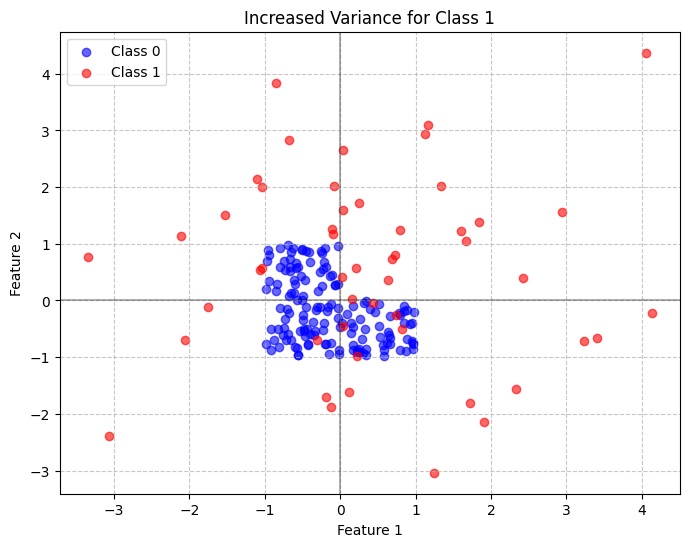

In [36]:
plot_data(X_high_var,y_high_var,'Increased Variance for Class 1')

In [37]:
#Separating indices by class
class0_idx = np.where(y_high_var == 0)[0]
class1_idx = np.where(y_high_var == 1)[0]

print("Original class distribution, Class 0:", len(class0_idx), "Class 1:", len(class1_idx))

#Creating test set with exactly 50 samples from each class
test_class0_idx = np.random.choice(class0_idx, size=50, replace=False)
test_class1_idx = np.random.choice(class1_idx, size=50, replace=False)
test_idx = np.concatenate([test_class0_idx, test_class1_idx])
np.random.shuffle(test_idx)  # Shuffle the test indices

#Creatinh the test set
X_high_var_test = X_high_var[test_idx]
y_high_var_test = y_high_var[test_idx]

#Getting the remaining indices for training
remaining_class0_idx = np.setdiff1d(class0_idx, test_class0_idx)
remaining_class1_idx = np.setdiff1d(class1_idx, test_class1_idx)

print("Remaining samples - Class 0:", len(remaining_class0_idx), "Class 1:", len(remaining_class1_idx))

#Checking if we have any remaining class 1 samples
if len(remaining_class1_idx) == 0:
    #if no Class 1 samples remain, use the original Class 1 samples with replacement
    print("No Class 1 samples remaining for training, using test samples with replacement")
    class1_upsampled = resample(class1_idx, 
                               replace=True, 
                               n_samples=len(remaining_class0_idx), 
                               random_state=42)
else:
    #Upsampling for training
    class1_upsampled = resample(remaining_class1_idx, 
                               replace=True, 
                               n_samples=len(remaining_class0_idx), 
                               random_state=42)

#Combine and shuffle for training
train_idx = np.concatenate([remaining_class0_idx, class1_upsampled])
np.random.shuffle(train_idx)

#Create the training set
X_high_var_train = X_high_var[train_idx]
y_high_var_train = y_high_var[train_idx]

print("Train set class distribution:", np.unique(y_high_var_train, return_counts=True))
print("Test set class distribution:", np.unique(y_high_var_test, return_counts=True))

Original class distribution, Class 0: 150 Class 1: 50
Remaining samples - Class 0: 100 Class 1: 0
No Class 1 samples remaining for training, using test samples with replacement
Train set class distribution: (array([0., 1.]), array([100, 100]))
Test set class distribution: (array([0., 1.]), array([50, 50]))


In [ ]:
svm_reasonable_c = SVC(kernel='rbf', C=10, random_state=42, probability=True)
svm_reasonable_c_metrics = evaluate_classifier(X_high_var_train, y_high_var_train, X_high_var_test, y_high_var_test, svm_reasonable_c)
print(f"Cross-Validation Accuracy: {svm_reasonable_c_metrics['cv_accuracy']:.4f}")
print(f"Cross-Validation Precision: {svm_reasonable_c_metrics['cv_precision']:.4f}")
print(f"Cross-Validation Recall: {svm_reasonable_c_metrics['cv_recall']:.4f}")
print(f"Cross-Validation AUROC: {svm_reasonable_c_metrics['cv_auroc']:.4f}")
print(f"Accuracy Variance: {svm_reasonable_c_metrics['accuracy_variance']:.6f}")
print(f"Test Set Accuracy: {svm_reasonable_c_metrics['test_accuracy']:.4f}")
print(f"Test Set Precision: {svm_reasonable_c_metrics['test_precision']:.4f}")
print(f"Test Set Recall: {svm_reasonable_c_metrics['test_recall']:.4f}")
print(f"Test Set AUROC: {svm_reasonable_c_metrics['test_auroc']:.4f}")

Cross-Validation Accuracy: 0.8950
Cross-Validation Precision: 0.9792
Cross-Validation Recall: 0.8100
Cross-Validation AUROC: 0.9652
Accuracy Variance: 0.000475
Test Set Accuracy: 0.9000
Test Set Precision: 1.0000
Test Set Recall: 0.8000
Test Set AUROC: 0.9380


Part4: Mismatch between Training and Test Data

In [39]:
svm_mismatch = SVC(kernel='rbf', C=10, random_state=42, probability=True)
svm_mismatch_metrics = evaluate_classifier(X_train, y_train, X_high_var_test, y_high_var_test, svm_mismatch)
print(f"Cross-Validation Accuracy: {svm_mismatch_metrics['cv_accuracy']:.4f}")
print(f"Cross-Validation Precision: {svm_mismatch_metrics['cv_precision']:.4f}")
print(f"Cross-Validation Recall: {svm_mismatch_metrics['cv_recall']:.4f}")
print(f"Cross-Validation AUROC: {svm_mismatch_metrics['cv_auroc']:.4f}")
print(f"Accuracy Variance: {svm_mismatch_metrics['accuracy_variance']:.6f}")
print(f"Test Set Accuracy: {svm_mismatch_metrics['test_accuracy']:.4f}")
print(f"Test Set Precision: {svm_mismatch_metrics['test_precision']:.4f}")
print(f"Test Set Recall: {svm_mismatch_metrics['test_recall']:.4f}")
print(f"Test Set AUROC: {svm_mismatch_metrics['test_auroc']:.4f}")

Cross-Validation Accuracy: 0.8750
Cross-Validation Precision: 0.9349
Cross-Validation Recall: 0.8100
Cross-Validation AUROC: 0.9316
Accuracy Variance: 0.000875
Test Set Accuracy: 0.9100
Test Set Precision: 0.9767
Test Set Recall: 0.8400
Test Set AUROC: 0.9388


Part5: High Variance with Reduced Training Set

In [46]:
X_high_var, y_high_var = generate_data_part(n_class0=150, n_class1=50, variance=1.5)

In [55]:
# Separating indices by class
class0_idx = np.where(y_high_var == 0)[0]
class1_idx = np.where(y_high_var == 1)[0]

print("Original class distribution, Class 0:", len(class0_idx), "Class 1:", len(class1_idx))

# Step 1: Create Training Data
if len(class0_idx) >= 60:
    train_class0_idx = np.random.choice(class0_idx, size=60, replace=False)
else:
    train_class0_idx = resample(class0_idx, replace=True, n_samples=60, random_state=42)

if len(class1_idx) >= 20:
    train_class1_idx = np.random.choice(class1_idx, size=20, replace=False)
else:
    train_class1_idx = resample(class1_idx, replace=True, n_samples=20, random_state=42)

# Combine and shuffle training indices
train_idx = np.concatenate([train_class0_idx, train_class1_idx])
np.random.shuffle(train_idx)

# Create training set
X_high_var_train = X_high_var[train_idx]
y_high_var_train = y_high_var[train_idx]

# Step 2: Use Remaining Data for Testing
remaining_class0_idx = np.setdiff1d(class0_idx, train_class0_idx)
remaining_class1_idx = np.setdiff1d(class1_idx, train_class1_idx)

test_idx = np.concatenate([remaining_class0_idx, remaining_class1_idx])
np.random.shuffle(test_idx)

# Create test set
X_high_var_test = X_high_var[test_idx]
y_high_var_test = y_high_var[test_idx]

# Output class distributions
print("Train set class distribution:", np.unique(y_high_var_train, return_counts=True))
print("Test set class distribution:", np.unique(y_high_var_test, return_counts=True))


Original class distribution, Class 0: 150 Class 1: 50
Train set class distribution: (array([0., 1.]), array([60, 20]))
Test set class distribution: (array([0., 1.]), array([90, 30]))


In [57]:
svm_reduced = SVC(kernel='rbf', C=10, random_state=42, probability=True)
svm_reduced_metrics= evaluate_classifier(X_high_var_train, y_high_var_train, X_high_var_test, y_high_var_test, svm_reduced)
print(f"Cross-Validation Accuracy: {svm_reduced_metrics['cv_accuracy']:.4f}")
print(f"Cross-Validation Precision: {svm_reduced_metrics['cv_precision']:.4f}")
print(f"Cross-Validation Recall: {svm_reduced_metrics['cv_recall']:.4f}")
print(f"Cross-Validation AUROC: {svm_reduced_metrics['cv_auroc']:.4f}")
print(f"Accuracy Variance: {svm_reduced_metrics['accuracy_variance']:.6f}")
print(f"Test Set Accuracy: {svm_reduced_metrics['test_accuracy']:.4f}")
print(f"Test Set Precision: {svm_reduced_metrics['test_precision']:.4f}")
print(f"Test Set Recall: {svm_reduced_metrics['test_recall']:.4f}")
print(f"Test Set AUROC: {svm_reduced_metrics['test_auroc']:.4f}")

Cross-Validation Accuracy: 0.8625
Cross-Validation Precision: 0.9375
Cross-Validation Recall: 0.5000
Cross-Validation AUROC: 0.8600
Accuracy Variance: 0.002969
Test Set Accuracy: 0.9333
Test Set Precision: 1.0000
Test Set Recall: 0.7333
Test Set AUROC: 0.9381
